In [1]:
!pip install forex-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import time
import joblib

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from forex_python.converter import CurrencyRates

###RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

In [3]:
def change_currency(val, curr_from, curr_to):
  if curr_from != curr_to:
    curr_from = curr_from.upper()
    curr_to = curr_to.upper()
    c = CurrencyRates()
    return round(val/c.get_rate(curr_to, curr_from))

In [4]:
def remove_mark(value):
    marks = ['>', '<', '-', '+', '_', ' ', '  ']
    for mark in marks:
        if pd.notna(value) and mark in value:
            return value.replace(mark, '')
    return value

In [5]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluates the performance of a regression model and provides a summary.

    Parameters:
        model: A trained regression model from scikit-learn.
        X_test: Test features.
        y_test: Test labels.
    """
    # Predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    r2 = r2_score(y_test, y_pred)

    # Display results
    print("Regression Model Evaluation:")
    print("===========================")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

## Reading initial data from API. In this step, we accept all offers from the API, but only receive general information. In order to complete the data, we also read each offer separately using its individual API.

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/dmarszalik/predict_salaries/main/clean_data.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16203 entries, 0 to 16202
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    16203 non-null  object 
 1   street                   16202 non-null  object 
 2   city                     16203 non-null  object 
 3   country_code             16195 non-null  object 
 4   address_text             16203 non-null  object 
 5   marker_icon              16203 non-null  object 
 6   workplace_type           16203 non-null  object 
 7   company_name             16203 non-null  object 
 8   company_url              16203 non-null  object 
 9   company_size             16203 non-null  object 
 10  experience_level         16203 non-null  object 
 11  latitude                 16203 non-null  float64
 12  longitude                16203 non-null  float64
 13  published_at             16203 non-null  object 
 14  remote_interview      

In [8]:
# Limit observations to those that have flag 'data'
df = df[df['marker_icon'] == 'data']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1539 entries, 31 to 16123
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    1539 non-null   object 
 1   street                   1539 non-null   object 
 2   city                     1539 non-null   object 
 3   country_code             1535 non-null   object 
 4   address_text             1539 non-null   object 
 5   marker_icon              1539 non-null   object 
 6   workplace_type           1539 non-null   object 
 7   company_name             1539 non-null   object 
 8   company_url              1539 non-null   object 
 9   company_size             1539 non-null   object 
 10  experience_level         1539 non-null   object 
 11  latitude                 1539 non-null   float64
 12  longitude                1539 non-null   float64
 13  published_at             1539 non-null   object 
 14  remote_interview         15

In [9]:
# putting all skills into 1 column
df_skill_1 = df.drop(columns = ['skill_2','skill_2_level','skill_3','skill_3_level'])
df_skill_2 = df.drop(columns = ['skill_1','skill_1_level','skill_3','skill_3_level'])
df_skill_3 = df.drop(columns = ['skill_1','skill_1_level','skill_2','skill_2_level'])
df_skill_1.sample()

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,...,skills,remote,multilocation,way_of_apply,type,from,to,currency,skill_1,skill_1_level
2409,Data Architect,-,Warszawa,PL,"-, Warszawa",data,partly_remote,Altkom Software & Consulting,https://altkomsoftware.pl/,250,...,"[{'name': 'ETL', 'level': 3}, {'name': 'Busine...",False,"[{'city': 'Warszawa', 'street': '-', 'slug': '...",redirect,b2b,NaN,NaN,NaN,ETL,3


In [10]:
df_skill_1.rename(columns={'skill_1': 'skill_name', 'skill_1_level': 'skill_level'}, inplace=True)
df_skill_2.rename(columns={'skill_2': 'skill_name', 'skill_2_level': 'skill_level'}, inplace=True)
df_skill_3.rename(columns={'skill_3': 'skill_name', 'skill_3_level': 'skill_level'}, inplace=True)
df_skills = pd.concat([df_skill_1, df_skill_2, df_skill_3])
df_skills.sample()

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,...,skills,remote,multilocation,way_of_apply,type,from,to,currency,skill_name,skill_level
604,Data Platform Engineer with German,Equal Business Park,Kraków,PL,"Equal Business Park, Kraków",data,remote,Qurate Retail Group,http://QurateRetailGroup.com,22 200+,...,"[{'name': 'Databases', 'level': 4}, {'name': '...",True,"[{'city': 'Gdańsk', 'slug': 'qurate-retail-gro...",redirect,permanent,18000.0,23000.0,pln,Databases,4.0


In [11]:
df_skills.reset_index(drop=True, inplace = True)
df_skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4617 entries, 0 to 4616
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    4617 non-null   object 
 1   street                   4617 non-null   object 
 2   city                     4617 non-null   object 
 3   country_code             4605 non-null   object 
 4   address_text             4617 non-null   object 
 5   marker_icon              4617 non-null   object 
 6   workplace_type           4617 non-null   object 
 7   company_name             4617 non-null   object 
 8   company_url              4617 non-null   object 
 9   company_size             4617 non-null   object 
 10  experience_level         4617 non-null   object 
 11  latitude                 4617 non-null   float64
 12  longitude                4617 non-null   float64
 13  published_at             4617 non-null   object 
 14  remote_interview        

In [12]:
most_common_skills = list(df_skills['skill_name'].value_counts().iloc[:20].index)
most_common_skills

['SQL',
 'Python',
 'ETL',
 'Machine Learning',
 'Power BI',
 'Databases',
 'BI',
 'T-SQL',
 'ETL tools',
 'Data',
 'AWS',
 'Big Data',
 'Spark',
 'Analytical Thinking',
 'PySpark',
 'Tableau',
 'AI',
 'Oracle',
 'PL/SQL',
 'DWH']

In [13]:
#select rows that contain most common skills only
df_most_common_skills=pd.DataFrame()

for row in range(len(df_skills)):
    if df_skills['skill_name'][row] in most_common_skills:
        df_most_common_skills= pd.concat([df_most_common_skills, df_skills.loc[[row]]])

df_most_common_skills

,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,company_url,company_size,...,skills,remote,multilocation,way_of_apply,type,from,to,currency,skill_name,skill_level
8,Lead Data Engineer - Commodity Insights,Centrum,Sopot,PL,"Centrum, Sopot",data,remote,S&P Global,https://www.spglobal.com/,>30000,...,"[{'name': 'Spark', 'level': 4}, {'name': 'Pyth...",True,"[{'city': 'Gdynia', 'slug': 's-p-global-lead-d...",form,permanent,22000.0,30000.0,pln,Spark,4.0
9,Senior Data Engineer -Commodity Insights,Centrum,Gdynia,PL,"Centrum, Gdynia",data,remote,S&P Global,https://www.spglobal.com/,>30000,...,"[{'name': 'AWS', 'level': 3}, {'name': 'Spark'...",True,"[{'city': 'Gdańsk', 'slug': 's-p-global-senior...",form,b2b,17750.0,26800.0,pln,AWS,3.0
11,Młodszy/a Specjalista/ka ds. wdrożeń systemów ...,Puławska 107,Warszawa,PL,"Puławska 107, Warszawa",data,partly_remote,Suntech,http://suntech.pl/pl/,10+,...,"[{'name': 'SQL', 'level': 2}, {'name': 'Analit...",False,"[{'city': 'Warszawa', 'street': 'Puławska 107'...",redirect,mandate_contract,NaN,NaN,NaN,SQL,2.0
12,Data Engineer,al. Jana Pawła II 34,Warszawa,PL,"al. Jana Pawła II 34, Warszawa",data,remote,Capco Poland,http://www.capco.com,200+,...,"[{'name': 'Python', 'level': 4}, {'name': 'Spa...",True,"[{'city': 'Katowice', 'slug': 'capco-poland-da...",redirect,b2b,25000.0,30000.0,pln,Python,4.0
13,Data Architect,Centrum,Kraków,PL,"Centrum, Kraków",data,remote,Concentrix,https://jobs.concentrix.com/global/en/concentr...,300 000,...,"[{'name': 'Python', 'level': 4}, {'name': 'Big...",True,"[{'city': 'Łódź', 'slug': 'concentrix-data-arc...",form,permanent,35000.0,41000.0,pln,Python,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,Data Scientist,Centrum,Poznań,PL,"Centrum, Poznań",data,remote,G2A,http://www.g2a.co,1-600,...,"[{'name': 'Python', 'level': 1}, {'name': 'Ana...",True,"[{'city': 'Poznań', 'street': 'Centrum', 'slug...",redirect,permanent,NaN,NaN,NaN,SQL,4.0
4607,Data Scientist,Centrum,Kraków,PL,"Centrum, Kraków",data,remote,G2A,http://www.g2a.co,1-600,...,"[{'name': 'Python', 'level': 1}, {'name': 'Ana...",True,"[{'city': 'Kraków', 'street': 'Centrum', 'slug...",redirect,permanent,NaN,NaN,NaN,SQL,4.0
4608,Data Scientist,Centrum,Rzeszów,PL,"Centrum, Rzeszów",data,remote,G2A,http://www.g2a.co,1-600,...,"[{'name': 'Python', 'level': 1}, {'name': 'Ana...",True,"[{'city': 'Rzeszów', 'street': 'Centrum', 'slu...",redirect,permanent,NaN,NaN,NaN,SQL,4.0
4609,Programista ETL /BI,Centrum,Wrocław,PL,"Centrum, Wrocław",data,remote,Pragmile,http://www.pragmile.com,80+,...,"[{'name': 'SQL', 'level': 3}, {'name': 'SSIS',...",True,"[{'city': 'Wrocław', 'street': 'Centrum', 'slu...",form,permanent,11000.0,16000.0,pln,ETL,3.0


In [14]:
df_most_common_skills.reset_index(inplace = True, drop = True)
df_most_common_skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    2465 non-null   object 
 1   street                   2465 non-null   object 
 2   city                     2465 non-null   object 
 3   country_code             2459 non-null   object 
 4   address_text             2465 non-null   object 
 5   marker_icon              2465 non-null   object 
 6   workplace_type           2465 non-null   object 
 7   company_name             2465 non-null   object 
 8   company_url              2465 non-null   object 
 9   company_size             2465 non-null   object 
 10  experience_level         2465 non-null   object 
 11  latitude                 2465 non-null   float64
 12  longitude                2465 non-null   float64
 13  published_at             2465 non-null   object 
 14  remote_interview        

In [15]:
#create a pivot with most common skills
df = df_most_common_skills.pivot(index = df_most_common_skills.columns.drop(['skill_name', 'skill_level']),
         columns = 'skill_name',
         values = 'skill_level').fillna(0).reset_index()

In [16]:
# encode values in column experience_level (label encoding), type (one-hot-encoding) and workplace_type (one-hot-encoding)

label_encoder = preprocessing.LabelEncoder()
df['experience_level']= label_encoder.fit_transform(df['experience_level'])
df['experience_level']

0       1
1       1
2       2
3       0
4       1
       ..
1269    2
1270    1
1271    1
1272    1
1273    1
Name: experience_level, Length: 1274, dtype: int64

In [17]:
df = pd.get_dummies(df, columns = ['type', 'workplace_type', 'country_code'], drop_first=True)

In [18]:
# convert all currencies to pln
currency_list = list(df[df['from'].notna()]['currency'].unique())
currency_list

['pln', 'eur', 'usd']

In [19]:
selected_currency  = 'pln'
foreign_currencies = currency_list.remove(selected_currency)
foreign_currencies

In [20]:
df_with_salary = df[df['currency'].notna()]
df_no_salary = df[df['currency'].isna()]

In [21]:
df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)
                                              if row['currency'] != selected_currency and pd.notna(row['currency'])
                                              else row['from'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_49552/2430910949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['from'] = df_with_salary.apply(lambda row: change_currency(row['from'], row['currency'], selected_currency)


In [22]:
df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)
                                            if row['currency'] != selected_currency and pd.notna(row['currency'])
                                            else row['to'], axis=1)

/var/folders/mp/mpgc14lx6b9f41xmhqs4mxc80000gn/T/ipykernel_49552/1341338040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_salary['to'] = df_with_salary.apply(lambda row: change_currency(row['to'], row['currency'], selected_currency)


In [23]:
df_with_salary.loc[df_with_salary['currency'] != selected_currency, 'currency'] = selected_currency

In [24]:
df = pd.concat([df_with_salary, df_no_salary])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 3 to 1271
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         1274 non-null   object 
 1   street                        1274 non-null   object 
 2   city                          1274 non-null   object 
 3   address_text                  1274 non-null   object 
 4   marker_icon                   1274 non-null   object 
 5   company_name                  1274 non-null   object 
 6   company_url                   1274 non-null   object 
 7   company_size                  1274 non-null   object 
 8   experience_level              1274 non-null   int64  
 9   latitude                      1274 non-null   float64
 10  longitude                     1274 non-null   float64
 11  published_at                  1274 non-null   object 
 12  remote_interview              1274 non-null   bool   
 13  open_to_

In [25]:
df.reset_index(drop=True, inplace = True)

In [26]:
#cleaning up and encoding company sizes

#cleaning up sizes that contain '-'
company_size_df = df[df['company_size'].str.contains('-')][['company_size']]

company_size_df['company_size_1'] = company_size_df['company_size'].str.split('-').str[0]
company_size_df['company_size_2']  = company_size_df['company_size'].str.split('-').str[-1]

company_size_df = company_size_df.dropna()

company_size_df['company_size_1'] = pd.to_numeric(company_size_df['company_size_1'])
company_size_df['company_size_2'] = pd.to_numeric(company_size_df['company_size_2'])
company_size_df['avg_company_size'] = (company_size_df['company_size_1'] + company_size_df['company_size_2']) / 2

company_size_df = company_size_df[['avg_company_size']]
company_size_df

,avg_company_size
0,75.0
4,17.5
26,17.5
27,17.5
28,17.5
...,...
1147,300.5
1148,3000.5
1218,1750.0
1219,95.0


In [27]:
df = pd.merge(df, company_size_df, left_index=True, right_index=True, how = 'outer')

In [28]:
df['company_size'] = df['company_size'].apply(remove_mark)

In [29]:
df['company_size'] = df['company_size'].apply(remove_mark)

In [30]:
df['company_size']

0       50100
1         100
2         100
3         200
4        1520
        ...  
1269     1000
1270     1000
1271     1000
1272      500
1273      500
Name: company_size, Length: 1274, dtype: object

In [31]:
#df['company_size'] = df['company_size'].replace('', None)
df['avg_company_size'] = df.apply(
    lambda row: row['company_size'] if pd.isna(row['avg_company_size']) else row['avg_company_size'],
    axis=1
).astype('float')

#df['avg_company_size'] = pd.to_numeric(df['avg_company_size'])

In [32]:
display(df.sample(5))
df.info()

,title,street,city,address_text,marker_icon,company_name,company_url,company_size,experience_level,latitude,...,type_mandate_contract,type_permanent,workplace_type_partly_remote,workplace_type_remote,country_code_DE,country_code_EE,country_code_MT,country_code_PL,country_code_UA,avg_company_size
259,Data Engineer,Polna 3a,Warszawa,"Polna 3a, Warszawa",data,Datumo,https://www.datumo.io,3040,1,52.214486,...,False,False,False,True,False,False,False,True,False,35.0
1058,Master Data Specialist,-,Rzeszów,"-, Rzeszów",data,Grupa KAN,http://www.kan-therm.com,501,1,50.041187,...,False,True,False,True,False,False,False,True,False,501.0
1142,Senior Data Analyst,Centrum,Poznań,"Centrum, Poznań",data,G2A,http://www.g2a.co,1600,2,52.409363,...,False,False,False,True,False,False,False,True,False,300.5
1184,Senior Data Scientist,-,Bydgoszcz,"-, Bydgoszcz",data,Limango Polska,http://limango.pl,500,2,53.123480,...,False,True,False,True,False,False,False,True,False,500.0
879,Data & Power BI Developer,-,Kraków,"-, Kraków",data,IT Squad,https://itsquad.pl/,70,2,50.064650,...,False,False,False,True,False,False,False,True,False,70.0


<class 'pandas.core.frame.DataFrame'>
Index: 1274 entries, 0 to 1273
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         1274 non-null   object 
 1   street                        1274 non-null   object 
 2   city                          1274 non-null   object 
 3   address_text                  1274 non-null   object 
 4   marker_icon                   1274 non-null   object 
 5   company_name                  1274 non-null   object 
 6   company_url                   1274 non-null   object 
 7   company_size                  1274 non-null   object 
 8   experience_level              1274 non-null   int64  
 9   latitude                      1274 non-null   float64
 10  longitude                     1274 non-null   float64
 11  published_at                  1274 non-null   object 
 12  remote_interview              1274 non-null   bool   
 13  open_to_

In [33]:
df.to_csv('df_pln.csv', index = False)

at this stage df includes:
- offers with marker icon 'data'
- ordered employment column
- cleaned company_size column
- selected offers with the 20 most popular skills among 'data', both with given and unknown salary
- experience_level, country_code, employment_type, workplace_type and skills encoded columns
- offers in a foreign currency converted into PLN

In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/df_pln.csv')

## Reading detailed data for every separete offer from API

In [35]:
# json_data = []

In [36]:
# offers = list(df.id)

In [37]:
# len(offers)

In [38]:
# for offer in offers:
#   url = f'https://justjoin.it/api/offers/{offer}'
#   response = requests.get(url)
#   json_obj = response.json()
#   # initial_df = pd.json_normalize(json_obj)
#   json_data.append(json_obj)
#   # time.sleep(0.5)

In [39]:
# df = pd.DataFrame(json_data)

In [40]:
# df.sample(10)

In [41]:
# from google.colab import files
# df.to_csv('data_offers.csv')

# files.download('data_offers.csv')

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/dmarszalik/predict_salaries/main/data_offers.csv')

In [43]:
df.sample(5)

,Unnamed: 0,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,id,tags,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile
1010,1010,NaN,Senior DWH Developer,Remote,Gdańsk,PL,"Remote, Gdańsk",data,remote,JellyTech Sp. z o.o.,...,jellytech-sp-z-o-o-senior-dwh-developer-gdansk,[],<h1><strong>Senior DWH Developer</strong></h1>...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'ETL', 'level': 4}, {'name': 'DWH', ...",True,"[{'type': 'b2b', 'salary': {'from': 18000, 'to...",[{'slug': 'jellytech-sp-z-o-o-senior-dwh-devel...,NaN
1256,1256,NaN,Analityk Biznesowo-Systemowy,Dąbrowskiego 44,Wrocław,PL,"Dąbrowskiego 44, Wrocław",data,partly_remote,Human Group,...,human-group-analityk-biznesowo-systemowy,[],<div>\n<strong>HUMAN GROUP </strong>to innowac...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'data analyst', 'level': 3}, {'name'...",False,"[{'type': 'b2b', 'salary': {'from': 6000, 'to'...",[{'slug': 'human-group-analityk-biznesowo-syst...,NaN
351,351,NaN,Remote SQL Developer,Centrum,Koszalin,PL,"Centrum, Koszalin",data,remote,Aplitt sp. z o.o.,...,aplitt-sp-z-o-o-remote-sql-developer-koszalin,[],<div><strong>Witamy w Aplitt. </strong></div><...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'T-SQL', 'level': 3}, {'name': 'MySQ...",True,"[{'type': 'permanent', 'salary': None}]",[{'slug': 'aplitt-sp-z-o-o-remote-sql-develope...,"{'url': '/brands/story/aplitt-sp-z-o-o', 'shor..."
303,303,NaN,Data Analyst,Centrum,Kraków,PL,"Centrum, Kraków",data,remote,Devire,...,devire-data-analyst-krakow,[],<div>Devire IT Outsourcing is a form of cooper...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'SQL', 'level': 4}, {'name': 'Python...",True,"[{'type': 'b2b', 'salary': {'from': 18500, 'to...","[{'slug': 'devire-data-analyst-krakow', 'city'...",NaN
673,673,NaN,Application / Database Manager,Remote,Białystok,PL,"Remote, Białystok",data,remote,Universal Investment,...,universal-investment-application-database-mana...,[],<div>Grow with us! Universal Investment is on ...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Oracle DB', 'level': 4}, {'name': '...",True,"[{'type': 'permanent', 'salary': None}]",[{'slug': 'universal-investment-application-da...,NaN


In [44]:
len(df)

1539

In [45]:
old_data = df.to_dict(orient='records')
new_data = []

# Iteracja przez wiersze DataFrame bazowego
for index, skill in enumerate(df['skills']):
    json_str = skill.replace("'", "\"")
    skills_list = json.loads(json_str)  # Przekształć string z skills na listę słowników
    for skill_dict in skills_list:
        new_row = old_data[index]
        new_row['skill'] = skill_dict['name']
        new_row['level'] = skill_dict['level']
        new_data.append(new_row)

In [46]:
new_df = pd.DataFrame(new_data)

In [47]:
new_df.skill.unique()

array(['Git', 'Akka', 'Terraform', 'Kubernetes', 'C++', 'JavaScript',
       'Websphere Datapower and GraphQL', 'Spark', 'AWS', 'Oracle Forms',
       'Esri/FME', 'GCP', 'Databases', 'Snowflake', 'Java',
       'data standards', 'Databricks', 'Confluence', 'NLP', 'Map/Reduce',
       'engineering', 'cicd', 'AWS/Azure', 'MS Excel', 'AI',
       'Microsoft Azure', 'Data Integration', 'Azure', 'DAX',
       'Deep Learning', 'Data', 'SSAS', 'Qlik Sense', 'PostgreSQL',
       'Elastic Cloud Kubernetes', 'MySQL', 'Python', 'Marketing Cloud',
       'BCBS 239', 'REST API', 'AIX', 'Oracle', 'SQL', 'Unix', 'DWH IBM',
       'ETL tools', 'Tableau', 'English', 'KPI', 'Google Loker Studio',
       'E-commerce', 'BI', 'Pandas', 'SAP BO', 'Qlik View', 'Hive',
       'DevOps', 'Google Cloud Platform', 'ERP', 'Jenkins', 'Scala',
       'BigData', 'Bash', 'Business Intelligence', 'Data Warehousing',
       'SAP', 'Go/Rust', 'ETL applications', 'NO-SQL Databases', 'Linux',
       'GB/GF', 'Data analysis

In [48]:
new_df.skill.nunique()

183

In [49]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

clean_df = standardize_text(new_df, "title")
clean_df = standardize_text(clean_df, "skill")


In [50]:
top_values = clean_df['skill'].value_counts().head(30)
top_30_skills = list(top_values.index)

In [51]:
clean_df.head(5)

,Unnamed: 0,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill,level
0,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
1,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
2,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
3,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
4,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3


In [52]:
top_30_skills

['gitlab',
 'azure',
 'amazon aws',
 'databricks',
 'sql',
 'english',
 'databases',
 'aix',
 'oltp',
 'ssas',
 'hadoop',
 'redshift',
 'data',
 'aws/azure',
 'python',
 'aws',
 'sap',
 'agile',
 'terraform',
 'git',
 'snowflake',
 'java',
 'optimizely',
 'data modeling',
 'kubernetes',
 'qlik view',
 'oracle',
 'elastic cloud kubernetes',
 'advanced databricks',
 'amazon redshift']

In [53]:
for index, skill in enumerate(clean_df['skill']):
  if any(item == skill for item in top_30_skills):
    break
  else:
    clean_df.loc[index, 'skill'] = None

In [54]:
# vectorizer = TfidfVectorizer()
# vetor_title = vectorizer.fit_transform(clean_df['title'])
# clean_df['vetor_title'] = vetor_title

In [55]:
clean_df.head(20)

,Unnamed: 0,apply_body,title,street,city,country_code,address_text,marker_icon,workplace_type,company_name,...,body,company_logo_url,banner_url,skills,remote,employment_types,multilocation,company_profile,skill,level
0,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
1,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
2,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
3,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
4,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
5,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
6,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
7,0,NaN,senior rust developer,"Św. Antoniego 2/4, Wrocław",Wrocław,PL,"Św. Antoniego 2/4, Wrocław, Wrocław",data,remote,Piwik PRO,...,<div>Dołączysz do doświadczonego zespołu progr...,https://bucket.justjoin.it/offers/company_logo...,NaN,"[{'name': 'Rust', 'level': 4}, {'name': 'Bazy ...",True,"[{'type': 'b2b', 'salary': {'from': 17000, 'to...",[{'slug': 'piwik-pro-senior-rust-developer-war...,{'url': '/brands/story/piwik-pro-bfe086f0-29ef...,git,3
8,1,NaN,spark / scala developer,Czesława Miłosza 9/9,Gdańsk,PL,"Czesława Miłosza 9/9, Gdańsk",data,remote,Scalac,...,<div>We are looking for a <strong>Scala/Sp

# BUILDING REGRESSION MODEL

In [56]:
df = pd.read_csv('https://raw.githubusercontent.com/KKozakiewicz/predict_salaries/main/df_pln.csv')

In [57]:
# remove columns that won't be taken into consideration
df=df.drop(columns = ['marker_icon','title','company_size', 'city','street','address_text','company_name',
                      'company_url', 'latitude','longitude', 'published_at','remote_interview', 'open_to_hire_ukrainians',
                      'id','display_offer', 'company_logo_url', 'skills','multilocation','way_of_apply', 'currency'])

In [58]:
# extract rows with no salary information
df_no_salaries = df[df['to'].isna()].reset_index()
#df_no_salaries.info()

# extract rows with salary information
df = df[df['to'].notna()].reset_index()
#df.info()

In [59]:
# split the dataset into training and test sets, now only salary_from is investigated
X = df.drop(columns=['from','to'])
y = df['from']

In [60]:
# normalizing the data
scl = StandardScaler()
X_scaled = pd.DataFrame(scl.fit_transform(X), columns = X.columns)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

## Random Forest

In [62]:
# Initialize the RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
gs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the GridSearchCV object to the training data
gs.fit(X_train, y_train)

# Get the best model with tuned hyperparameters
best_model = gs.best_estimator_

# Print best parameters
print("Best Parameters:", gs.best_params_)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_regression_model(best_model, X_test, y_test)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Regression Model Evaluation:
Mean Absolute Error (MAE): 619.27
Mean Squared Error (MSE): 2569404.98
Root Mean Squared Error (RMSE): 1602.94
R-squared (R2): 0.94


In [63]:
y_pred

array([10000.        , 20364.        , 14617.42666667, 15015.        ,
       27447.20666667, 20364.        , 19000.        , 18975.46666667,
        9980.        , 16800.        , 15455.        , 13926.66666667,
       13401.        , 14617.42666667, 15634.        , 17955.73333333,
       17220.        , 17000.        , 17763.33333333, 35000.        ,
       19000.        , 20118.33333333,  6165.33333333,  9990.        ,
       35000.        , 23948.1       , 20000.        , 20364.        ,
       15000.        , 16098.10666667, 16580.74      , 20364.        ,
       35000.        ,  8500.        , 11653.86666667, 19966.66666667,
       17772.00666667, 35000.        , 18000.        , 17980.8       ,
       19533.83333333, 16633.        , 33803.33333333, 14494.66666667,
       13000.        ,  7020.        , 10066.66666667, 18000.        ,
       15200.4       , 20000.        , 15634.        , 17235.        ,
       25006.66666667, 35000.        , 15455.        , 23642.56666667,
      

In [64]:
RF_model = RandomForestRegressor(max_depth=20,min_samples_split = 2, n_estimators = 150)
RF_model.fit(X_train, y_train)

evaluate_regression_model(RF_model, X_test, y_test)

Regression Model Evaluation:
Mean Absolute Error (MAE): 609.15
Mean Squared Error (MSE): 2481655.30
Root Mean Squared Error (RMSE): 1575.33
R-squared (R2): 0.94


##MAE distribution

<Axes: ylabel='Count'>

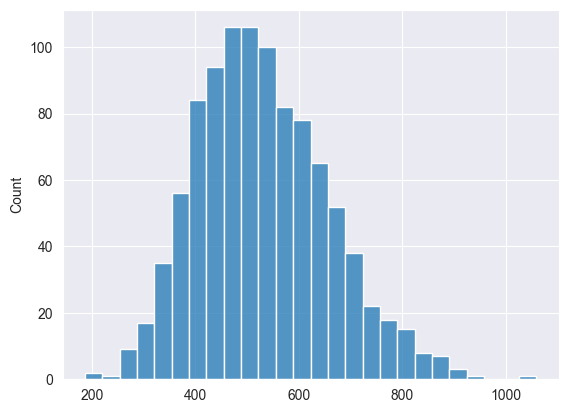

In [65]:
mae = []

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    RF_model = RandomForestRegressor(max_depth=20,min_samples_split = 2, n_estimators = 150)

    RF_model.fit(X_train, y_train)

    mae.append(mean_absolute_error(y_test, RF_model.predict(X_test)))

sns.set_style("darkgrid")
sns.histplot(mae)